In [7]:
### Benjamin Tollison ###
import cvxpy as cp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def PlotSturcture(N,C,color:str):
    m,_ = C.shape
    for i in range(m):
        ii = np.nonzero(C[i])
        plt.plot(N[0,ii][0],N[1,ii][0],color)
        plt.axis('equal')
def DistanceChecker(x1,y1,x2,y2,delta):
  dx,dy = delta, delta
  distance_between_x = abs(x1 - x2)
  distance_between_y = abs(y1 - y2)
  if distance_between_x < dx*2**0.5 + dx/5 and distance_between_y < dy*2**0.5 + dy/5:
     return True
  else:
     return False
def is_repeat_pattern(patterns, new_pattern):
    new_tuple = tuple(new_pattern)
    seen_tuples = set(map(tuple, patterns))
    if new_tuple in seen_tuples:
        return True
    else:
        return False
def BuildConnectivityMatrix(number_of_members,number_of_nodes,cooridnate_matrix,delta):
  C = np.zeros((number_of_members,number_of_nodes))
  C_duplicate = []
  member = 0
  for node in range(number_of_nodes-1):
    for other_node in range(1,number_of_nodes):
      predetermined_indices = [node,other_node]  # Indices where you want to put 1s
      duplicate_check_tuple= tuple(1 if i in predetermined_indices else 0 for i in range(number_of_nodes))
      if is_repeat_pattern(C_duplicate,duplicate_check_tuple):
          duplicate_check_bool = False
      else:
          duplicate_check_bool = True
          C_duplicate.append(duplicate_check_tuple)
      node_x1,node_y1 = cooridnate_matrix[0][node], cooridnate_matrix[1][node]
      node_x2,node_y2 = cooridnate_matrix[0][other_node], cooridnate_matrix[1][other_node]
      if other_node != node and DistanceChecker(node_x1,node_y1,node_x2,node_y2,delta) and duplicate_check_bool and member < number_of_members:
        C[member][node], C[member][other_node] = 1, -1
        member += 1
  print("Built C matrix ;)")
  return C
def ProblemSolution(node_y_count:int):
  length = 4
  height = 1
  delta = 1/node_y_count
  print(f'loading: {round(delta,4)}')
  x_step_number = int(length/delta)
  y_step_number = int(height/delta)
  number_of_nodes = x_step_number*y_step_number
  x_coords = np.linspace(0, length, x_step_number)
  y_coords = np.linspace(0, height, y_step_number)
  X, Y = np.meshgrid(x_coords, y_coords)
  N = np.vstack((X.ravel(), Y.ravel()))
  number_of_members = int(6 + 5*(np.sqrt(number_of_nodes)-2) + (np.sqrt(number_of_nodes)-2)*(5+4*(np.sqrt(number_of_nodes)-2)))
  plt.scatter(N[0],N[1])
  axis = plt.gca()
  axis.set_aspect('equal',adjustable='box')
  C_B = BuildConnectivityMatrix(number_of_members,number_of_nodes,N,delta)
  C_S = C_B
  PlotSturcture(N,C_B,'k')
  plt.title(f'Mesh Structure for dx ={round(delta,4)}')
  plt.show()
  # plt.scatter(N[0],N[1])
  # axis = plt.gca()
  # axis.set_aspect('equal',adjustable='box')
  # PlotSturcture(N,C_S,'r')
  # plt.title('Cable Mesh')
  # plt.show()
  print(f'finished {delta}')
  R = cp.Variable((2,number_of_nodes))
  sigma_B = cp.Variable(number_of_members)
  sigma_S = cp.Variable(number_of_members)
  free_nodes = [i for i in np.where(N[0] != 0.0)]
  R = cp.Variable((2,number_of_nodes))
  sigma_B = cp.Variable(number_of_members)
  sigma_S = cp.Variable(number_of_members)
  free_nodes = [i for i in np.where(N[0] != 0.0)]
  F_ext = np.zeros((2, number_of_nodes))
  far_right_nodes = [i for i in map(list,np.where(N[0] == length))]
  node_where_F_is_applied = np.argmin(np.abs(N[1][far_right_nodes] - height/2))
  P = -1
  F_ext[1][far_right_nodes[0][node_where_F_is_applied]] = P
  Constraints = [N @ C_S.T @ cp.diag(sigma_S) @ C_S - N @ C_B.T @ cp.diag(sigma_B) @ C_B - F_ext - R == 0,
                R[:,free_nodes[0]] == 0,
                sigma_B >= 0,
                sigma_S >= 0]
  Cost = cp.norm(sigma_B,2) + cp.norm(sigma_S,2)
  prob = cp.Problem(cp.Minimize(Cost), Constraints)
  prob.solve(solver=cp.ECOS)
  # pd.DataFrame(sigma_B.value).to_csv('sigma_bar.csv')
  # pd.DataFrame(sigma_S.value).to_csv('sigma_cable.csv')
  # pd.DataFrame((R.value).T).to_csv('reaction.csv')
  sigma_bar_member_indices = np.where(sigma_B.value >= 1*10**-3)[0]
  sigma_cable_member_indices = np.where(sigma_S.value >= 1*10**-3)[0]
  C_B_final = np.zeros((number_of_members,number_of_nodes))
  C_S_final = C_B_final
  C_B_final = C_B[sigma_bar_member_indices]
  C_S_final = C_S[sigma_cable_member_indices]
  PlotSturcture(N,C_B_final,'k')
  PlotSturcture(N,C_S_final,'r')
  plt.title('Minimum Stress Solution')
  plt.show()
  Constraints = [N @ C_S.T @ cp.diag(sigma_S) @ C_S - N @ C_B.T @ cp.diag(sigma_B) @ C_B - F_ext - R == 0,
                R[:,free_nodes[0]] == 0,
                sigma_B >= 0,
                sigma_S >= 0]
  Cost = cp.norm(sigma_B,1) + cp.norm(sigma_S,1)
  prob = cp.Problem(cp.Minimize(Cost), Constraints)
  prob.solve(solver=cp.ECOS)
  # pd.DataFrame(sigma_B.value).to_csv('sigma_bar.csv')
  # pd.DataFrame(sigma_S.value).to_csv('sigma_cable.csv')
  # pd.DataFrame((R.value).T).to_csv('reaction.csv')
  sigma_bar_member_indices = np.where(sigma_B.value >= 1*10**-3)[0]
  sigma_cable_member_indices = np.where(sigma_S.value >= 1*10**-3)[0]
  C_B_final = np.zeros((number_of_members,number_of_nodes))
  C_S_final = C_B_final
  C_B_final = C_B[sigma_bar_member_indices]
  C_S_final = C_S[sigma_cable_member_indices]
  PlotSturcture(N,C_B_final,'k')
  PlotSturcture(N,C_S_final,'r')
  plt.title('Sparsity Solution')
  plt.show()

loading: 0.3333
Built C matrix ;)


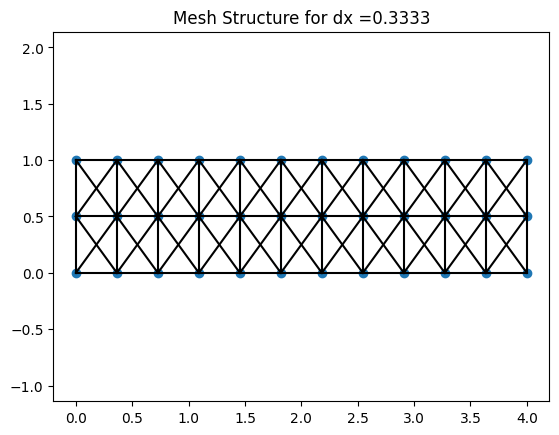

finished 0.3333333333333333


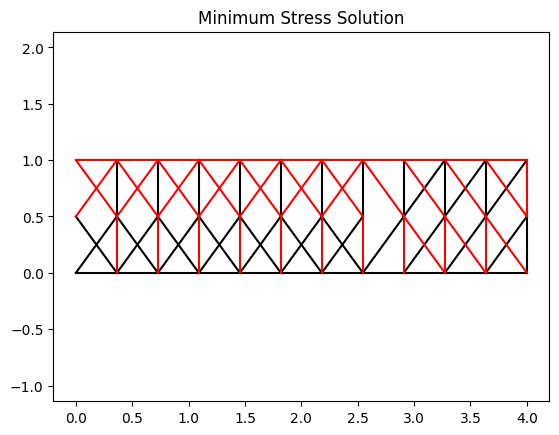

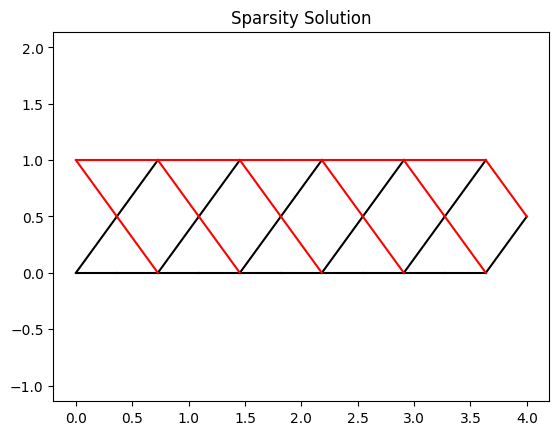

loading: 0.2


KeyboardInterrupt: 

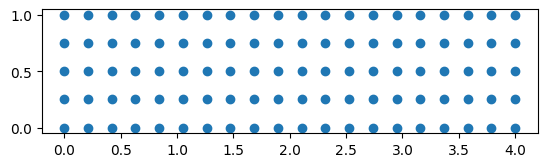

In [8]:
for i in [3,5,7,9]:
  ProblemSolution(i)

loading: 0.3333
Built C matrix ;)


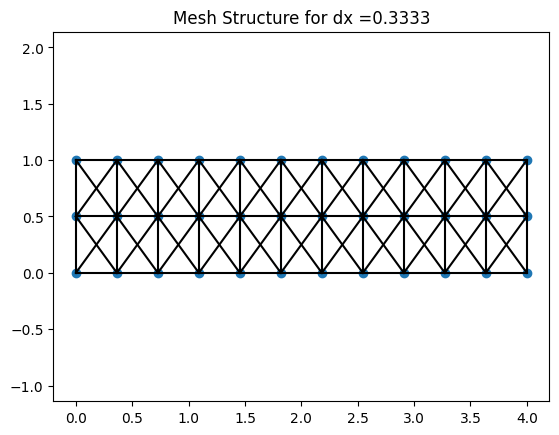

finished 0.3333333333333333


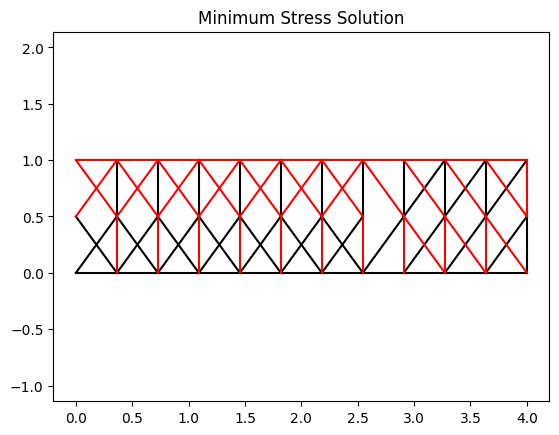

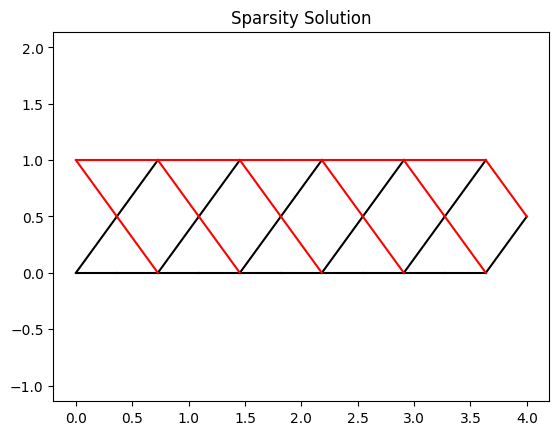

loading: 0.2
Built C matrix ;)


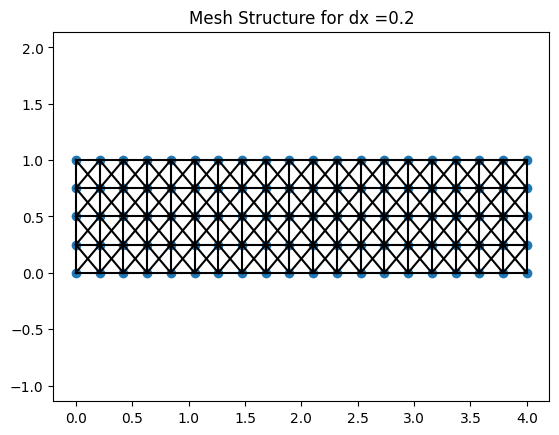

finished 0.2


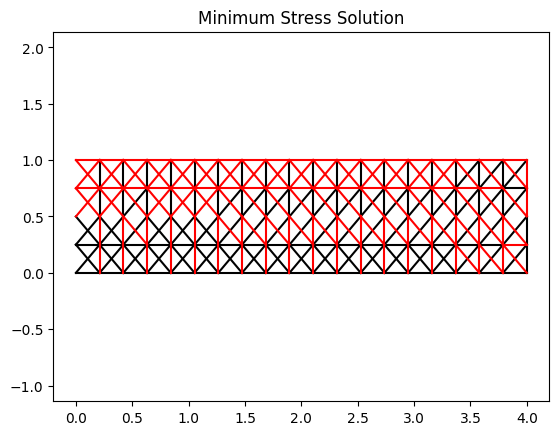

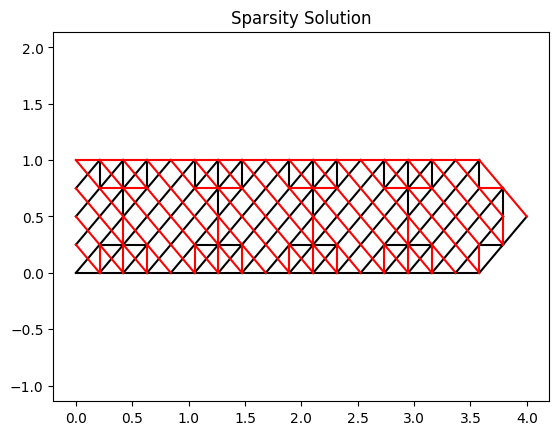

loading: 0.1429
Built C matrix ;)


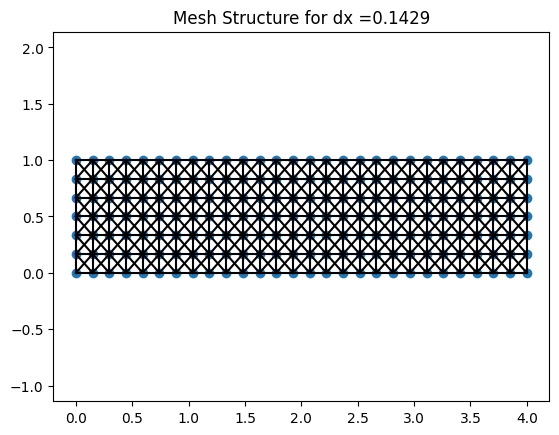

finished 0.14285714285714285


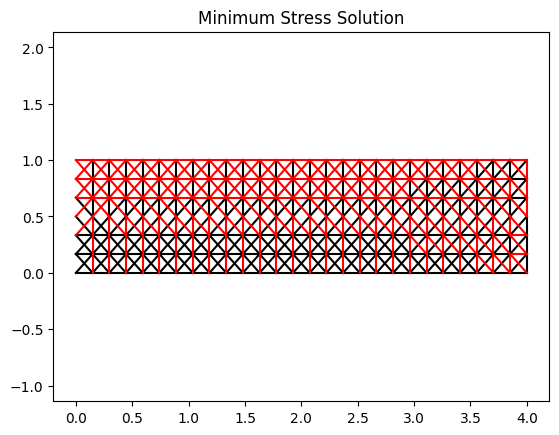

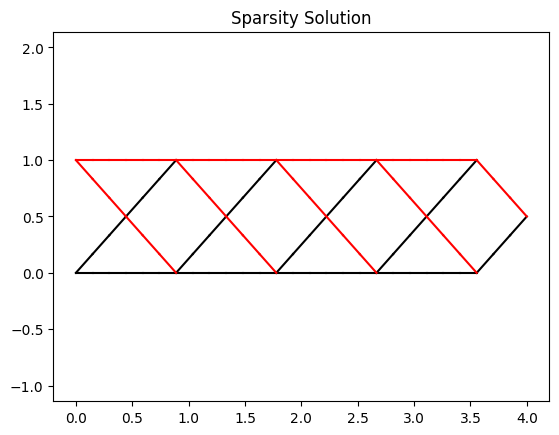

loading: 0.1111
Built C matrix ;)


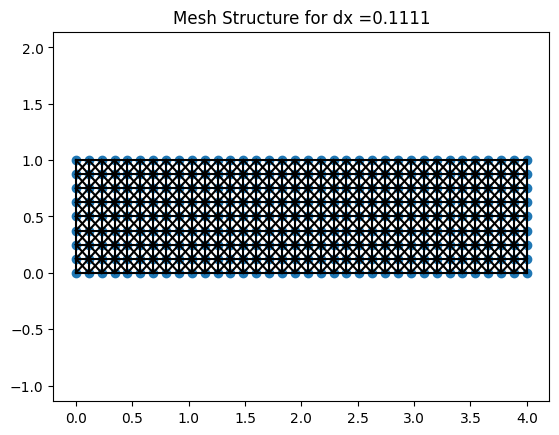

finished 0.1111111111111111


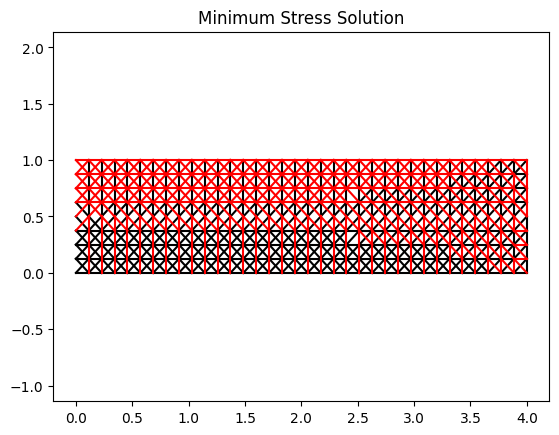

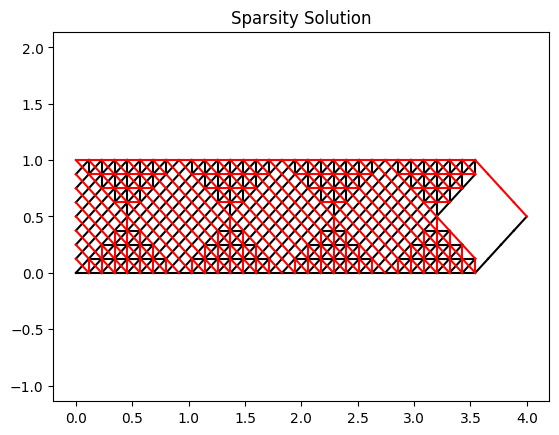

loading: 0.0909
Built C matrix ;)


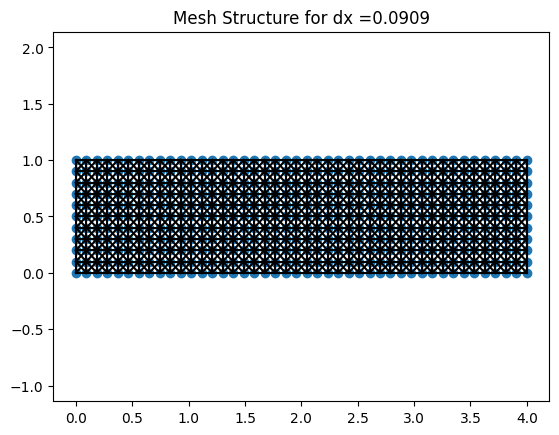

finished 0.09090909090909091


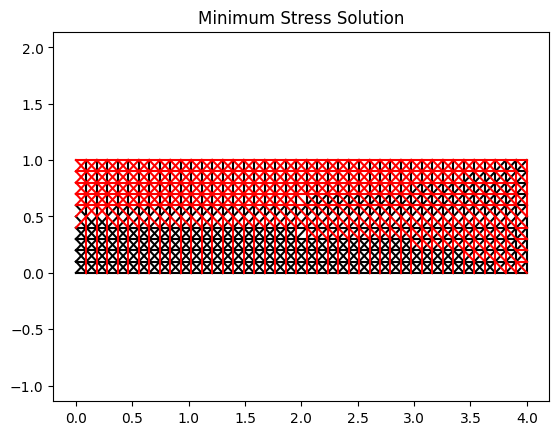

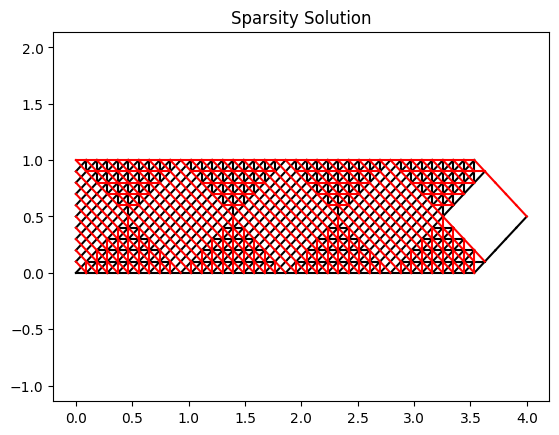

In [ ]:

for i in [3,5,7,9,11]:
  ProblemSolution(i)